In [1]:
#install poppler dependency for pdf2image
!apt-get install poppler-utils 
!apt install tesseract-ocr
!apt install libtesseract-dev

# install opencv and pdf2image
!pip3 install opencv-python pdf2image pytesseract

# import libraries
import os
import cv2
import numpy as np
import PIL
import pytesseract as pt

from pdf2image import convert_from_path
from PIL import Image
from numpy import *
from pytesseract import Output



Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [2]:
pdfimages = convert_from_path('std200.pdf')
num_pages = len(pdfimages)

for i in range(num_pages):
   
      # Save pages as images in the pdf
    pdfimages[i].save('page'+ str(i) +'.jpg', 'JPEG')

  
# read image into array
image_array = cv2.imread('page4.jpg')

In [3]:
#Convert the image to grayscale
gray_scale = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

#Apply thresholding to image
_, img_bin = cv2.threshold(gray_scale, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255 - img_bin

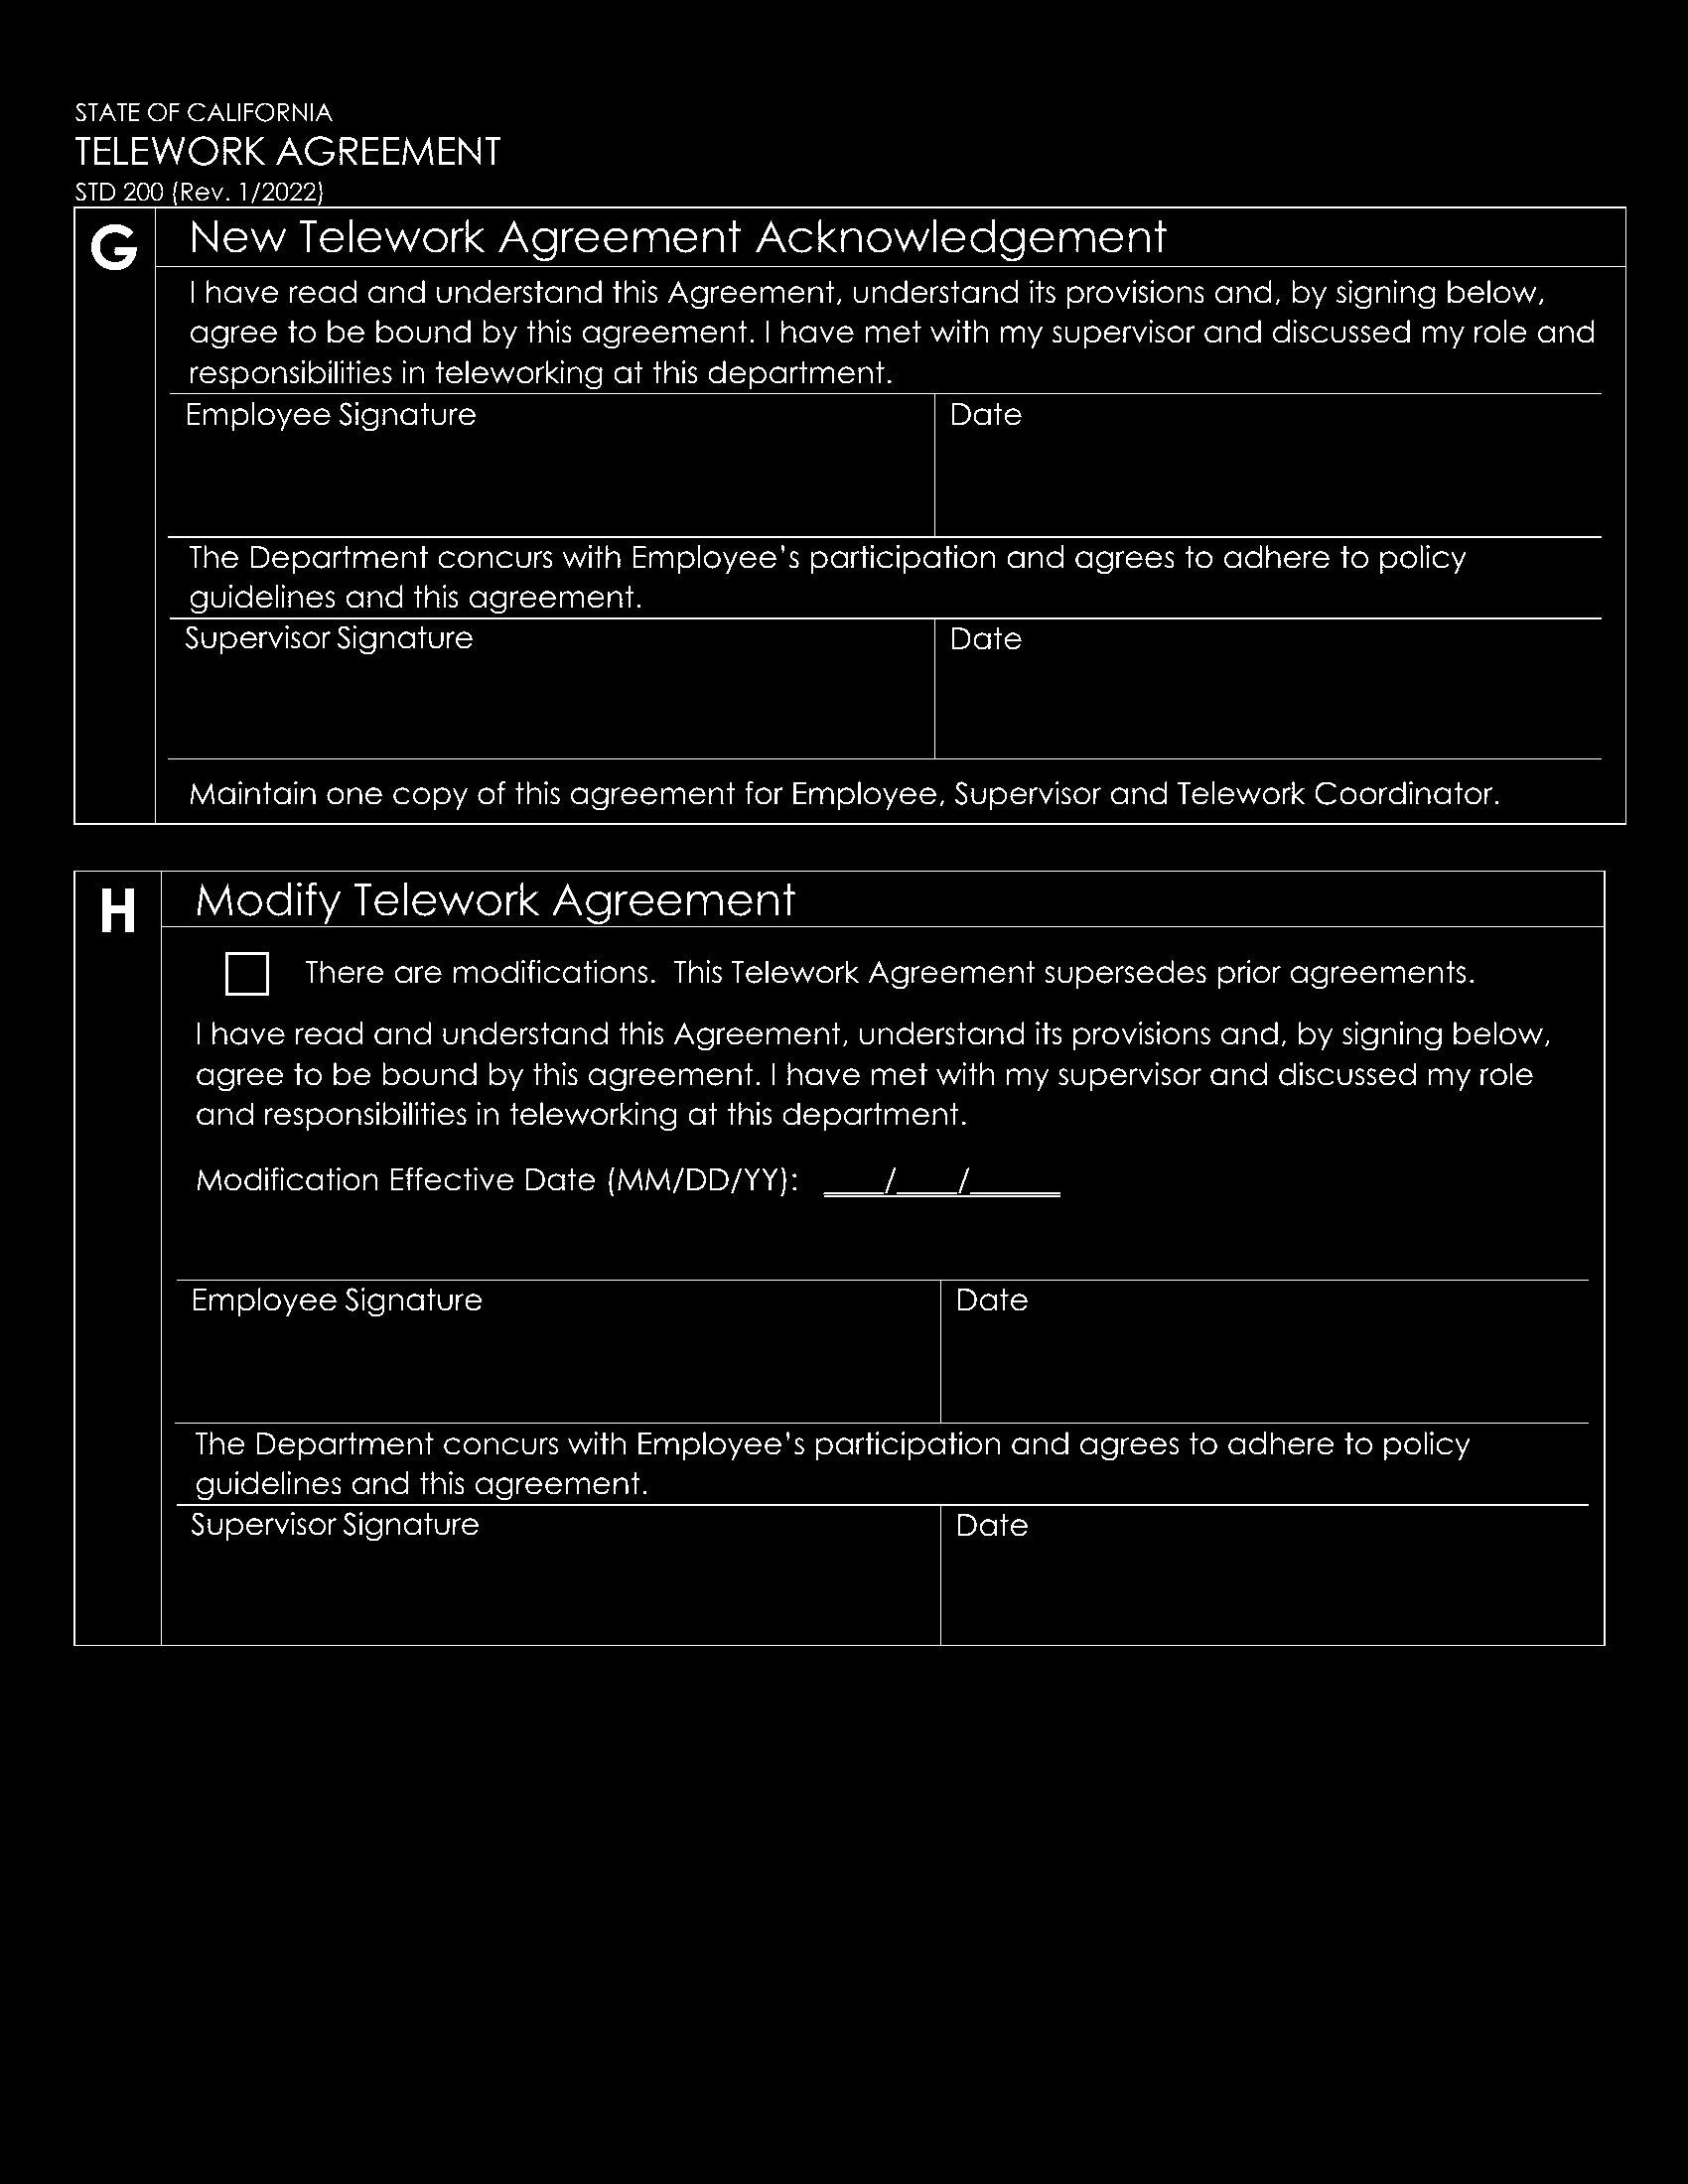

In [4]:
#Display grayscaled image
Image.fromarray(img_bin)

In [5]:
#Define a min width for line detection
line_min_width = 15

#Create the kernel to detect horizontal lines
kernal_h = np.ones((1,line_min_width), np.uint8)

#Create the kernel to detect vertical lines
kernal_v = np.ones((line_min_width,1), np.uint8)

#Apply horizontal kernel on the image
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)

#Apply verical kernel on the image
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)


#Combine the kernels
img_bin_final=img_bin_h|img_bin_v

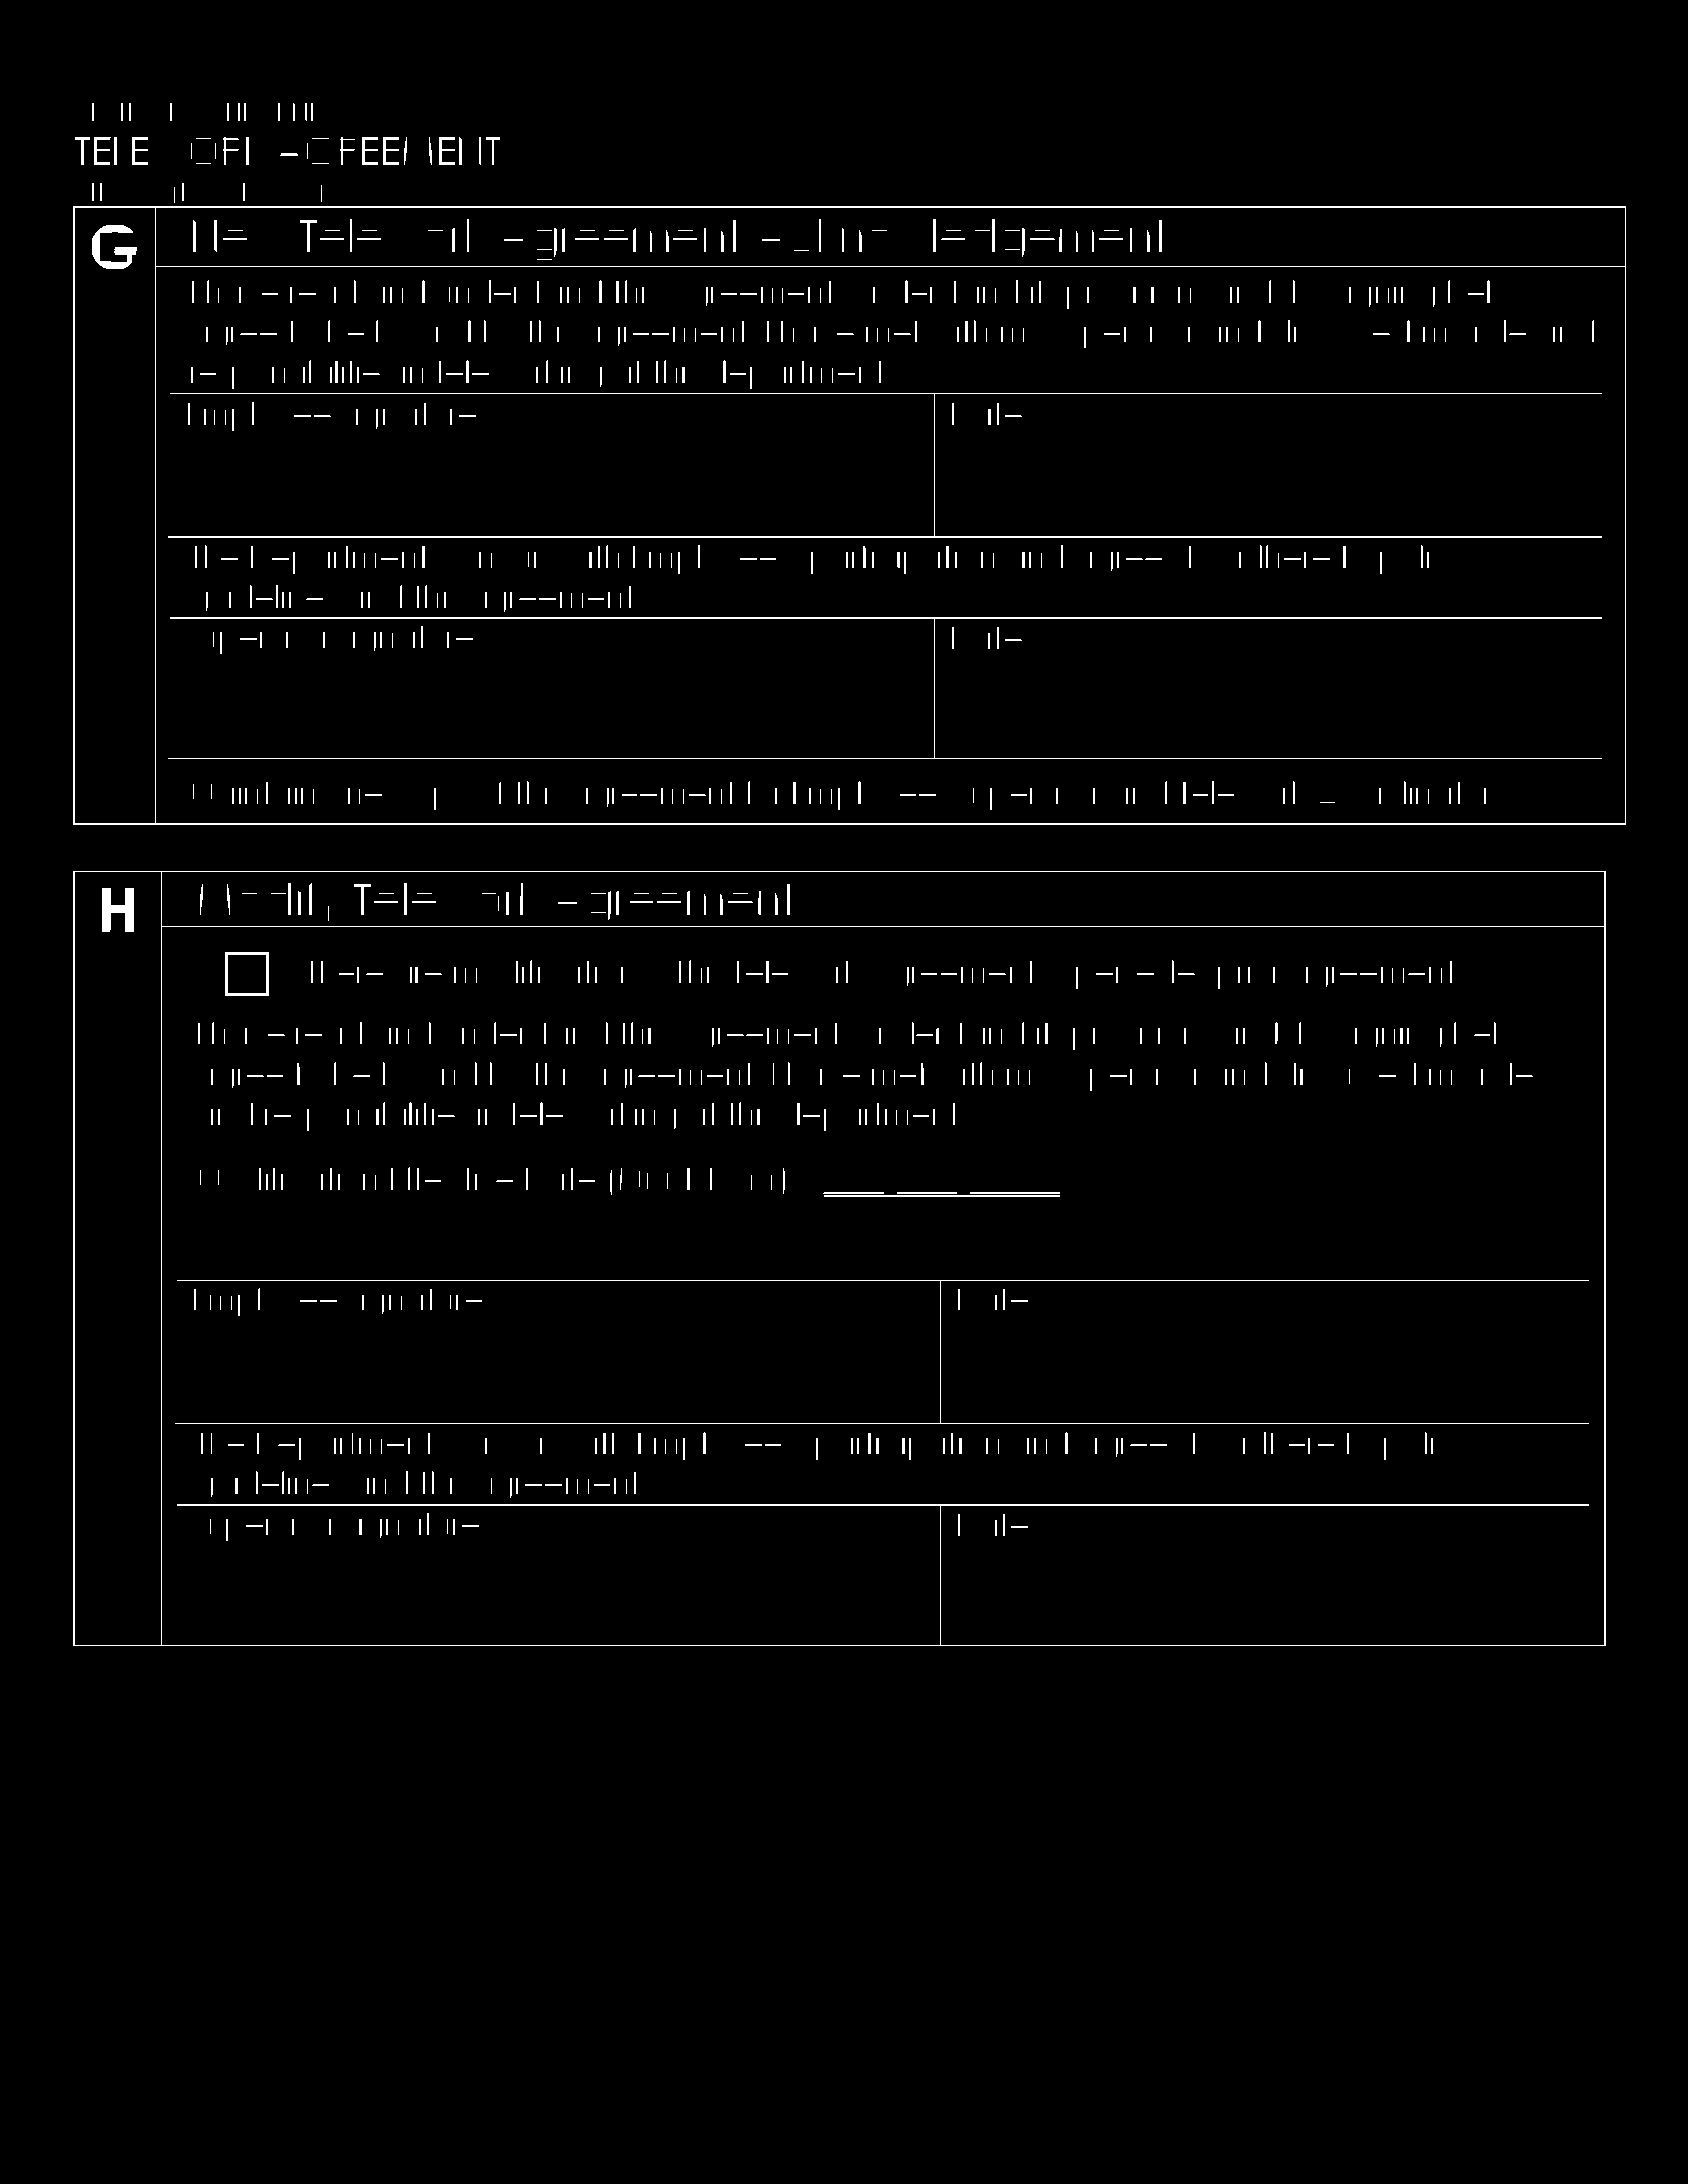

In [6]:
Image.fromarray(img_bin_final)

In [7]:
#Set parameters for Hough Line Transformation
minLineLength =  1000
minLineGap = 10

#Identify lines via Probabilistic Hough Line Transformation
lines = cv2.HoughLinesP(img_bin_final, 1, np.pi / 180, minLineLength, minLineGap)

In [8]:
#Calculates coordinates and area of boxes
_, labels, stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

In [9]:

#Initialize our vector of textless boxes
#need initial vector to achieve the correct dimensions for concatenation
blankBoxes = np.array([(0,0,0,0,0)])
signatureBoxes = np.array([(0,0,0,0,0)])

#Remove boxes with text
for x,y,w,h,area in stats[2:]:

    #Create a cropped image with just the select box
    crop_img = image_array[y:y+h, x:x+w]

    #Read text from box
    img_text = pt.image_to_string(crop_img)

    #If there's no text and the box is a reasonable size, add to array
    if (not img_text.strip()) and (area > 200) and (not w*2 < h) and (not h*2 < w):
        blankBoxes = np.concatenate((blankBoxes, [(x,y,w,h,area)]), axis=0)
blankBoxes = np.delete(blankBoxes, [0], axis=0)

In [10]:
#Remove vertical or irregularly angled lines from set of possible lines
horiz_lines = np.array([(0,0,0,0)])
for i in range(0, len(lines)):
  l = lines[i][0]
  x1 = l[0]
  y1 = l[1]
  x2 = l[2]
  y2 = l[3]

  #Find the angle of the line
  angle = np.degrees(np.arctan2(y2-y1,x2-x1))

  #Check for horizontal lines
  if(np.absolute(angle) <= 10):

    #Add horizontal lines to array
    horiz_lines = np.concatenate((horiz_lines, [(x1,y1,x2,y2)]), axis=0)

horiz_lines = np.delete(horiz_lines, [0], axis=0)


In [11]:
#Read text from page
d = pt.image_to_data(image_array, output_type=Output.DICT)
signature_locations = np.array([(0,0,0,0)])
for i in range(0, len(d["text"])):

  #Search for signature identifiers in text
  if(d["text"][i].upper() == "SIGNATURE"):
    x = d["left"][i]
    y = d["top"][i]
    w = d["width"][i]
    h = d["height"][i]
    
    #Add to array of signature locations
    signature_locations = np.concatenate((signature_locations, [(x,y,w,h)]), axis=0)
signature_locations = np.delete(signature_locations, [0], axis=0)

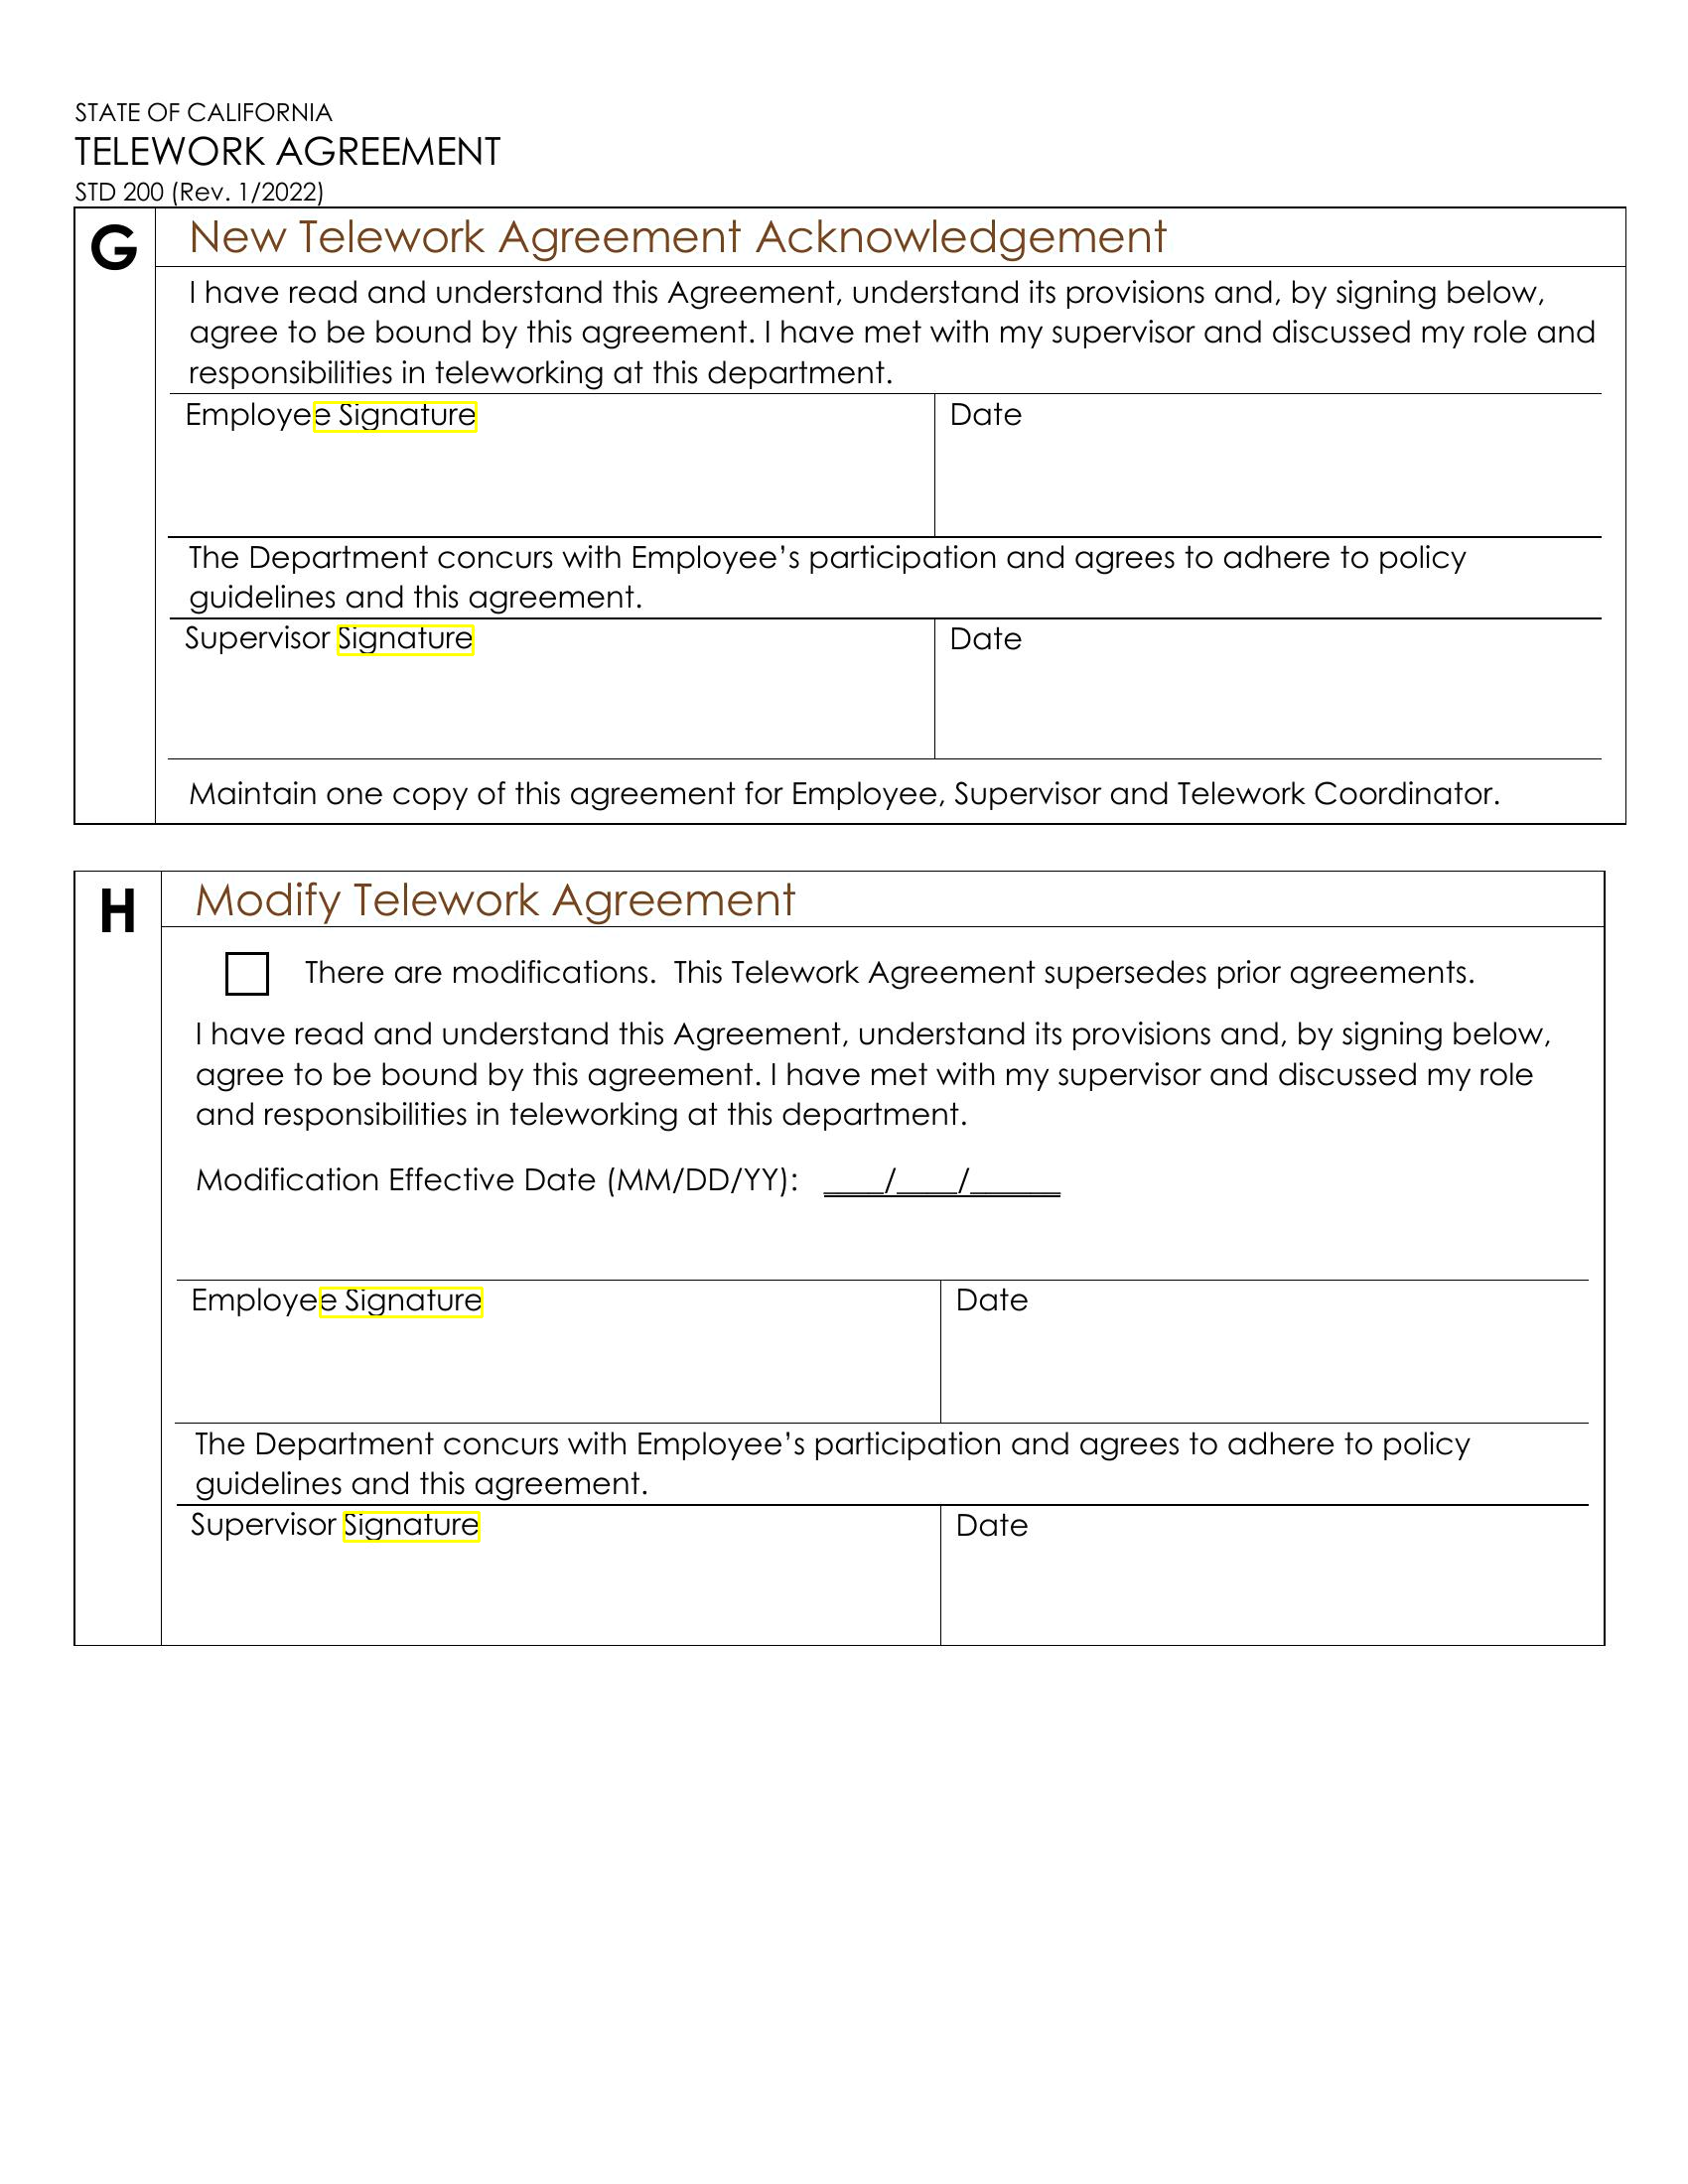

In [12]:
for x,y,w,h in signature_locations:
    #Apply rectangle outline
    cv2.rectangle(image_array,(x,y),(x+w,y+h),(255,255,0),2)

Image.fromarray(image_array)

In [13]:
#Search for viable signature lines based on signature identifiers
signature_lines = np.array([(0,0,0,0)])
for x,y,w,h in signature_locations:
  dist_above = 0
  dist_below =  0
  closest_above = np.empty([1,4])
  closest_below = np.empty([1,4])

  #Check for nearest lines
  for x1,y1,x2,y2 in horiz_lines:
    above = False
    dist = y1-y

    #Check if line is above or below
    if(dist > 0):
      above = True

    #Check for closest line above
    if(above == True and (dist_above == 0 or dist < dist_above)):
      closest_above = [(x1,y1,x2,y2)]
      dist_above = dist

    #Check for closest line below
    if(above == False and (dist_below == 0 or np.absolute(dist) < dist_below)):
      closest_below = [(x1,y1,x2,y2)]
      dist_below = np.absolute(dist)
  #Save closest lines
  signature_lines = np.concatenate((signature_lines, closest_above, closest_below), axis=0)
signature_lines = np.delete(signature_lines, [0], axis=0)

In [14]:
#Draw lines
#if signature_lines is not None:
      #for x1,y1,x2,y2 in signature_lines:
            #cv2.line(image_array, (x1, y1), (x2, y2), (0,0,255), 3, cv2.LINE_AA)
#Image.fromarray(image_array)

In [15]:
#Find signature boxes from signature lines
signature_boxes = np.array([(0,0,0,0)])
for i in range(0, len(signature_locations)):
  #Get location and dimensions of signature identifier
  loc =  signature_locations[i]
  x = loc[0]
  y = loc[1]
  w = loc[2]
  h = loc[3]
  for x1, y1, x2, y2 in signature_lines[(i*2):((i*2)+1)]:
    #Check above line for conflicts
    check_x = x+w
    check_y = y1-h
    check_w = (x2-x1)//2-check_x
    check_h = h
    #Create a cropped image with just the select box
    crop_img = image_array[check_y:check_y+check_h, check_x:check_x+check_w]
    #Read text from box
    img_text = pt.image_to_string(crop_img)
    #Check for empty space
    if not img_text.strip():
      signature_boxes = np.concatenate((signature_boxes, [(check_x, check_y, check_w, check_h)]))
signature_boxes = np.delete(signature_boxes, [0], axis=0)

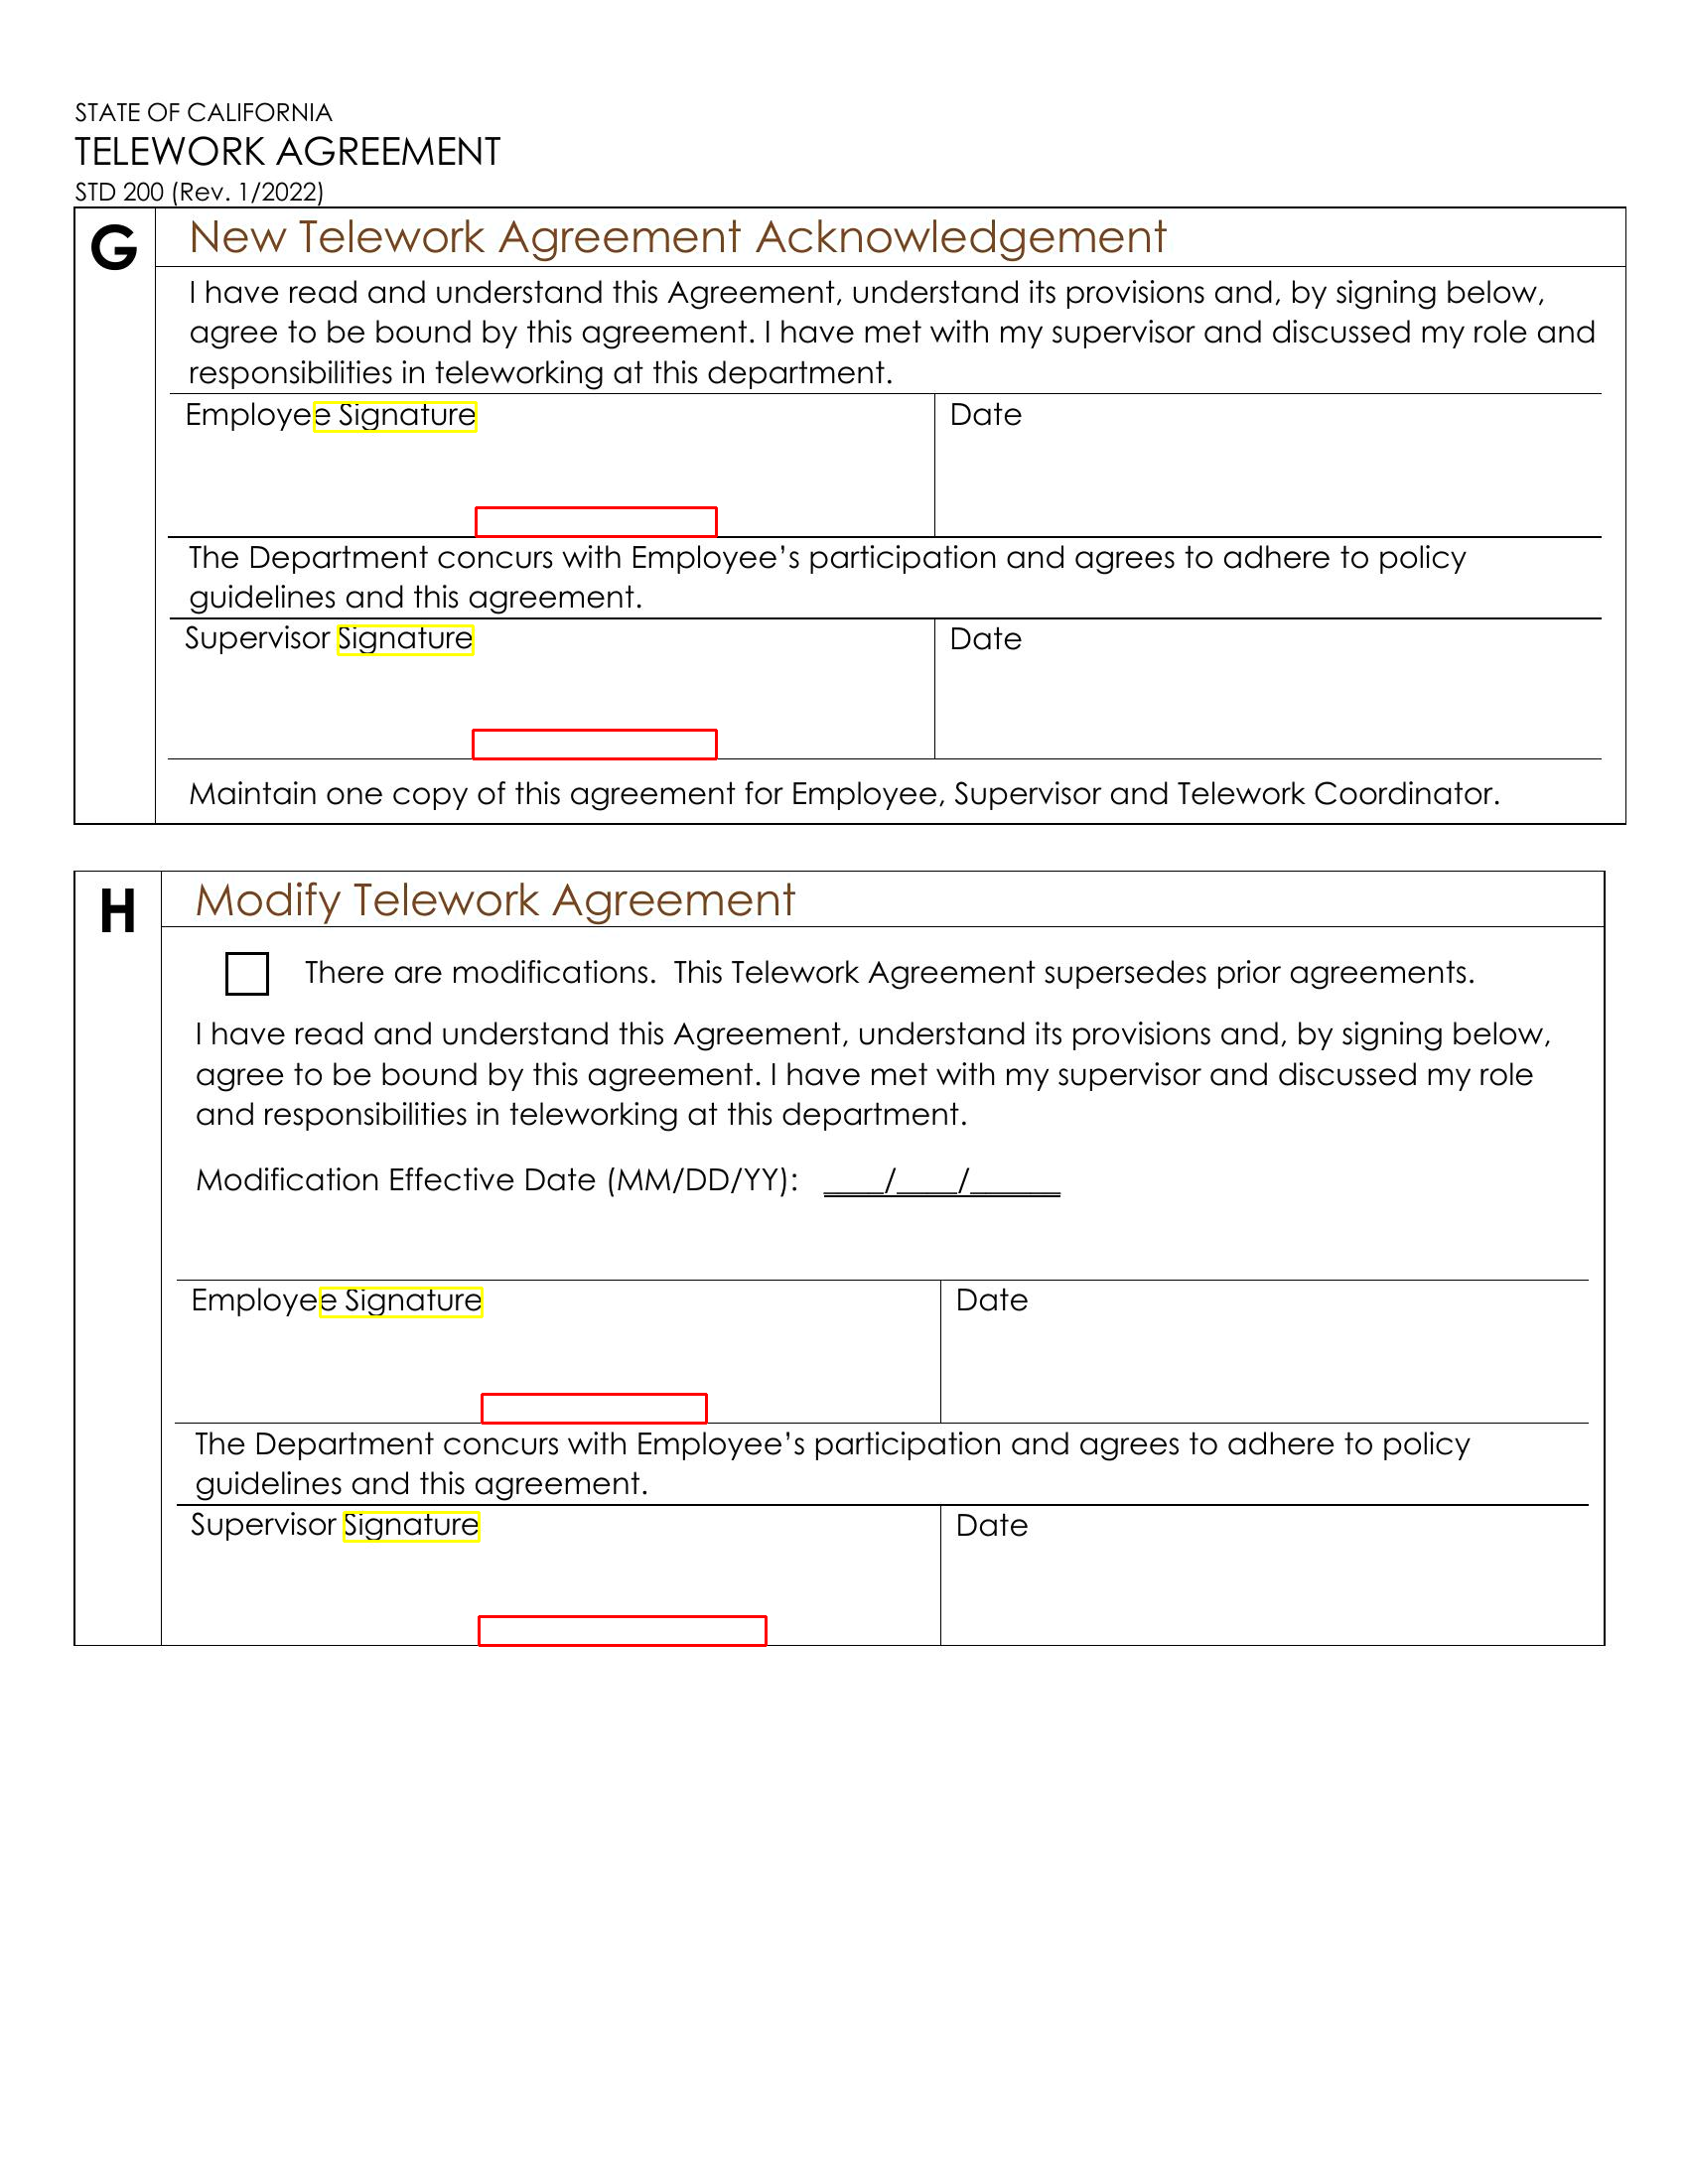

In [16]:
for x,y,w,h in signature_boxes:
    #Apply rectangle outline
    cv2.rectangle(image_array,(x,y),(x+w,y+h),(255,0,0),2)

Image.fromarray(image_array)

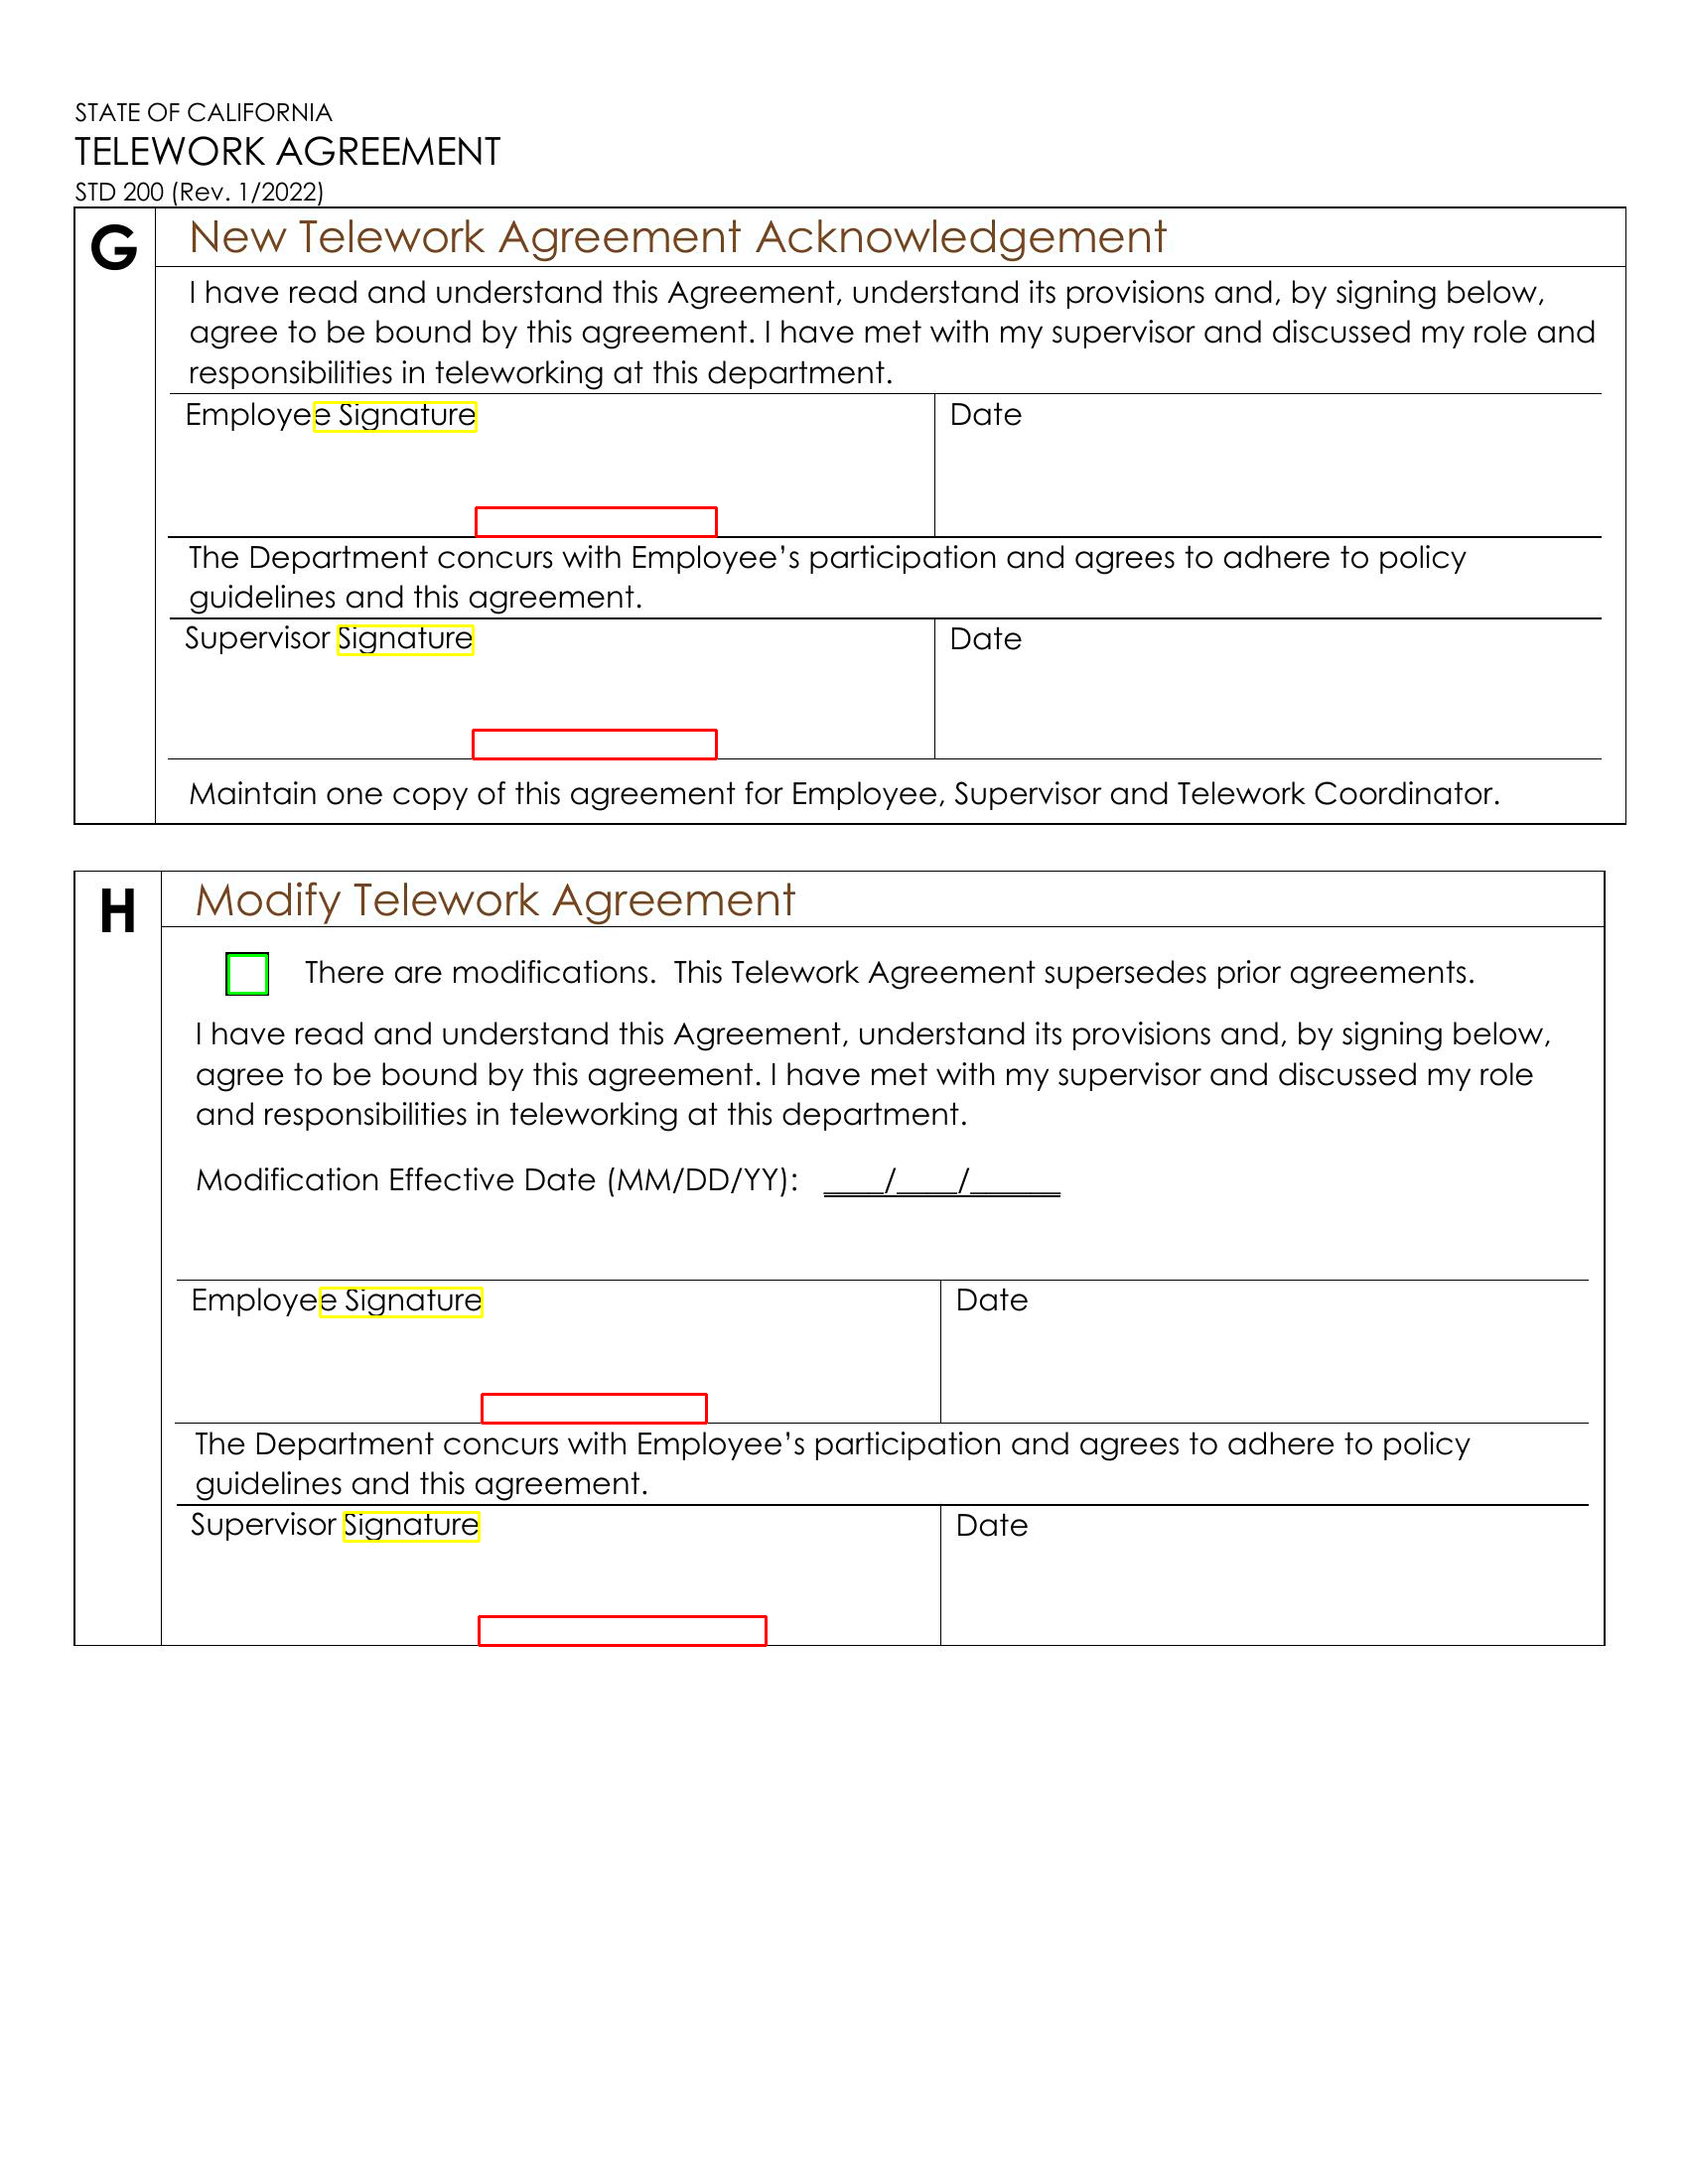

In [17]:
#Paint box boundaries and mark corners
for x,y,w,h,area in blankBoxes:
    #Apply rectangle outline
    cv2.rectangle(image_array,(x,y),(x+w,y+h),(0,255,0),2)
    #Apply upper left corner marker (Red)
    #cv2.circle(image_array, (x,y), 10, (255,0,0), -1)


#Second loop to layer markers correctly
#for x,y,w,h,area in blankBoxes:
    #Apply bottom right corner marker (Blue)
    #cv2.circle(image_array, (x+w,y+h), 5, (0,0,255), -1)


Image.fromarray(image_array)